# Modeling Pipeline
## Stroke Risk Prediction

This notebook implements a reproducible machine learning pipeline for stroke risk prediction.

Objectives:
- Prevent data leakage via proper train/test separation
- Build a structured preprocessing pipeline
- Train a Logistic Regression baseline model
- Evaluate performance using discrimination and threshold analysis
- Perform cost-sensitive threshold optimization


## 1. Imports


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    auc,
    precision_score,
    recall_score
)

import joblib

## 2. Data Loading


In [5]:
# Load dataset
df = pd.read_csv("../data/raw/healthcare-dataset-stroke-data.csv")

# Create BMI missingness indicator (binary)
df["bmi_missing"] = df["bmi"].isna().astype(int)

# Define predictors (X) and target (y)
X = df.drop(columns=["id", "stroke"])
y = df["stroke"]

## 3. Train-Test Split

Data is split before any preprocessing to prevent data leakage.
Stratified sampling preserves class imbalance across sets.


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

## 4. Feature Grouping


In [9]:
numeric_cols = ["age", "avg_glucose_level", "bmi"]
binary_cols = ["hypertension", "heart_disease", "bmi_missing"]
categorical_cols = ["gender", "ever_married", "work_type", "Residence_type", "smoking_status"]

## 5. Preprocessing Pipeline

- Numeric: median imputation + standardization
- Binary: passthrough
- Categorical: one-hot encoding (drop first to avoid multicollinearity)


In [11]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = OneHotEncoder(
    drop="first",
    handle_unknown="ignore"
)

column_transformer = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("bin", "passthrough", binary_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

## 6. Logistic Regression Model


In [13]:
logreg_pipeline = Pipeline(steps=[
    ("preprocessing", column_transformer),
    ("model", LogisticRegression(
        class_weight="balanced",
        max_iter=1000,
        random_state=42
    ))
])

logreg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'avg_glucose_level',
                                                   'bmi']),
                                                 ('bin', 'passthrough',
                                                  ['hypertension',
                                                   'heart_disease',
                                                   'bmi_missing']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['gender', 'ever_married',
                                                   'work_type',
                                                   'Residence_type',
                                                   'smoking_status'])])),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

## 7. Model Evaluation


In [15]:
# Predicted probabilities for positive class
y_proba = logreg_pipeline.predict_proba(X_test)[:, 1]

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC: {roc_auc:.3f}")

ROC-AUC: 0.843


### Precision-Recall Analysis


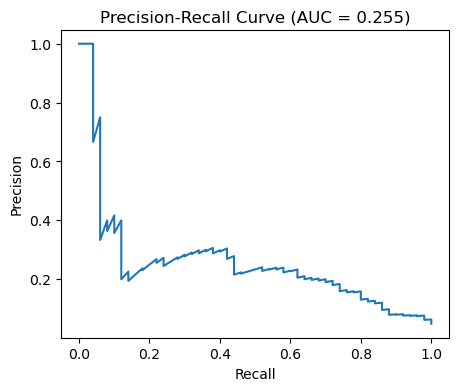

PR-AUC: 0.255


In [17]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)

plt.figure(figsize=(5,4))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall Curve (AUC = {pr_auc:.3f})")
plt.show()

print(f"PR-AUC: {pr_auc:.3f}")

## 8. Cost-Sensitive Threshold Optimization

Thresholds are selected under varying false-negative to false-positive cost ratios.


In [19]:
cost_ratios = [2, 5, 10]
thresholds = np.linspace(0.0, 1.0, 201)

results = []

for ratio in cost_ratios:
    best_cost = np.inf
    best_threshold = None
    
    for t in thresholds:
        y_pred_t = (y_proba >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_t).ravel()
        
        total_cost = fn * ratio + fp
        
        if total_cost < best_cost:
            best_cost = total_cost
            best_threshold = t
    
    results.append((ratio, best_threshold, best_cost))

results

[(2, 0.9550000000000001, 95), (5, 0.8250000000000001, 196), (10, 0.68, 290)]

In [29]:
# Export full preprocessing + model pipeline for deployment
# This allows consistent scoring in external applications (e.g., Streamlit app or API)
joblib.dump(logreg_pipeline, "model.joblib")

['model.joblib']

## 9. Conclusion

This modeling workflow demonstrates the development of a decision-aware risk scoring engine.

Key components implemented:

- Structured preprocessing pipeline to prevent data leakage
- Logistic Regression baseline with class imbalance handling
- Evaluation using ROC-AUC and Precision-Recall metrics
- Threshold tuning under multiple false-negative to false-positive cost assumptions

Rather than relying on a fixed 0.5 classification threshold, the model’s decision boundary was optimized based on operational trade-offs. This reflects real-world deployment considerations, where model outputs must align with system constraints and risk tolerance.

This pipeline is production-ready and can be exported as a reusable scoring component for downstream applications (e.g., API service or interactive interface).